In [12]:
from mpmath import *
import numpy as np
import math
import random
import time
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
mass = [173.0,173.0]

In [3]:
alpha = 1/137.0
rts = 1000.0
Nc = 3
Qt = 2/3
CF = 4/3
als = 1/10

In [4]:
def alam(a,b,c):
  return a**2+b**2+c**2 - 2*a*b -2*a*c -2*b*c

In [5]:
def dot4(p1,p2):
  return p1[0]*p2[0]-p1[1]*p2[1]-p1[2]*p2[2]-p1[3]*p2[3]

In [6]:
def generatemomenta(xv,rts,masses):
  mtilde1 = rts
  mtilde2 = masses[1]
  psqi = alam(mtilde1**2,masses[0]**2,mtilde2**2)/(4.0*mtilde1**2)
  ei = math.sqrt(psqi+masses[0]**2)
  pi = math.sqrt(psqi)
  costhi = 1-2*xv[1]
  sinthi = math.sqrt(1-costhi**2)
  phi = 2.0*math.pi*xv[0]
  pmom = np.array([ei,pi*sinthi*math.sin(phi),pi*sinthi*math.cos(phi),pi*costhi])
  wps = pi/(4.0*math.pi*mtilde1)
  return [pmom,wps]

In [7]:
def matrixelement(tt,mm2):
    return (1 + 2*mm2**2 + 2*tt - 4*mm2*tt + 2*tt**2)

In [8]:
def matrixelement1L(tt,mm2):
    result = (-8*mm2*(pow(mm2,2) + tt - 2*mm2*tt + pow(tt,2))*log((1 - sqrt(1 - 4*mm2))/(1 + sqrt(1 - 4*mm2))))/sqrt(1 - 4*mm2) + (1 + 2*pow(mm2,2) + 2*tt - 4*mm2*tt + 2*pow(tt,2))*(-4 + 3*sqrt(1 - 4*mm2)*log((1 + sqrt(1 - 4*mm2))/(1 - sqrt(1 - 4*mm2))) - 2*log(1/mm2) + ((2 - 4*mm2)*log((1 + sqrt(1 - 4*mm2))/(1 - sqrt(1 - 4*mm2)))*log(1/mm2))/sqrt(1 - 4*mm2) + ((2 - 4*mm2)*((2*pow(pi,2))/3. - pow(log((1 - sqrt(1 - 4*mm2))/(1 + sqrt(1 - 4*mm2))),2)/2. + 2*log((1 - sqrt(1 - 4*mm2))/(1 + sqrt(1 - 4*mm2)))*log((2*sqrt(1 - 4*mm2))/(1 + sqrt(1 - 4*mm2))) + 2*polylog(2,(1 - sqrt(1 - 4*mm2))/(1 + sqrt(1 - 4*mm2)))))/sqrt(1 - 4*mm2))
    return result

In [9]:
factor0L = Nc*Qt**2*32*alpha**2*math.pi**2
factor1L = factor0L*(als/2/pi)*CF

In [10]:
print(matrixelement1L(1.1,.2))

100.156909578073


In [11]:
Nshot = 1000000

In [13]:
random.seed(9172025)
sigma=0.0
var=0.0
bin = [0]*20
start_time_func = time.time() # Record start time ⏰

for i in range(Nshot):
  xrand = [random.random(),random.random()]
  mtilde1 = rts
  mtilde2 = mass[1]
  pmomout = generatemomenta(xrand,rts,mass)
  pmom1 = pmomout[0]
  pmom2 = np.multiply(pmom1,np.array([1,-1,-1,-1]))
  bmom1 = np.array([rts/2,0,0,rts/2])
  bmom2 = np.array([rts/2,0,0,-rts/2])
  #msq = 32*math.pi**2*alpha**2/dot4(bmom1,bmom2)**2*( dot4(bmom2,pmom1)*dot4(bmom1,pmom2) + dot4(bmom1,pmom1)*dot4(bmom2,pmom2) + dot4(bmom1,pmom2)*mass[0]*mass[1] )
  tt = (mass[0]**2 - 2*dot4(bmom1,pmom1))/(2*dot4(bmom1,bmom2))
  mm2 = mass[0]**2/(2*dot4(bmom1,bmom2))
  #msq = Nc*Qt**2*32*alpha**2*math.pi**2*matrixelement(tt,mm2)  # msq for 0L
  msq = factor1L*matrixelement1L(tt,mm2)
  flux = 1/4/dot4(bmom1,bmom2)
  wps = pmomout[1]*msq*flux*389000000
  sigma = sigma + wps/Nshot
  var = var + wps**2/Nshot
  costheta = (bmom1[0]*pmom1[0]-dot4(bmom1,pmom1))/bmom1[0]/math.sqrt(pmom1[1]**2+pmom1[2]**2+pmom1[3]**2)
  nbin = math.ceil(costheta*10 + 10)-1
  #print(nbin)
  bin[nbin]=bin[nbin]+wps/Nshot*10
  if (i + 1) % (Nshot // 10) == 0 and i > 0:
    print(f"  ... Completed {i + 1} / {Nshot} iterations ({((i + 1) / Nshot):.0%})")


end_time_func = time.time() # Record end time ⏰
duration_func = end_time_func - start_time_func
print(f"Time taken: {duration_func:.4f} seconds")
print("-" * 40)

  ... Completed 100000 / 1000000 iterations (10%)
  ... Completed 200000 / 1000000 iterations (20%)
  ... Completed 300000 / 1000000 iterations (30%)
  ... Completed 400000 / 1000000 iterations (40%)
  ... Completed 500000 / 1000000 iterations (50%)
  ... Completed 600000 / 1000000 iterations (60%)
  ... Completed 700000 / 1000000 iterations (70%)
  ... Completed 800000 / 1000000 iterations (80%)
  ... Completed 900000 / 1000000 iterations (90%)
  ... Completed 1000000 / 1000000 iterations (100%)
Time taken: 434.2628 seconds
----------------------------------------


In [14]:
# Define the path to your saved model file
model_filepath = './ThreeLayer-NLO-3/best_model.keras'
# Load the model from the file
# This will restore the model's architecture, weights, and optimizer state.
loaded_model = keras.models.load_model(model_filepath)

# The 'loaded_model' is now ready to be used just like the original model.
print("Model loaded successfully!")

Model loaded successfully!


In [17]:
import time
import random
import math
import numpy as np

# --- Prerequisites ---
# This code assumes the following variables are already defined:
# Nshot, rts, mass, factor1L, generatemomenta, dot4, loaded_model

random.seed(9172025)

# ===================================================================
# STEP 1: COLLECT ALL INPUTS AND OTHER NECESSARY DATA
# First, we loop through the simulation just to gather all the data
# we will need for prediction and later calculations.
# ===================================================================
print("\n--- Step 1: Collecting data from simulation loop... ---")
start_time_collect = time.time() # Record start time for this step

list_of_model_inputs = []
list_of_other_data = []

for i in range(Nshot):
    # Generate momenta and kinematic variables
    xrand = [random.random(), random.random()]
    pmomout = generatemomenta(xrand, rts, mass)
    pmom1 = pmomout[0]
    bmom1 = np.array([rts / 2, 0, 0, rts / 2])
    bmom2 = np.array([rts / 2, 0, 0, -rts / 2])

    tt = (mass[0]**2 - 2 * dot4(bmom1, pmom1)) / (2 * dot4(bmom1, bmom2))
    mm2 = mass[0]**2 / (2 * dot4(bmom1, bmom2))

    # Append the [tt, mm2] pair for the model
    list_of_model_inputs.append([tt, mm2])

    # Store other values we will need in the final calculation loop
    flux = 1 / 4 / dot4(bmom1, bmom2)
    costheta = (bmom1[0] * pmom1[0] - dot4(bmom1, pmom1)) / bmom1[0] / math.sqrt(
        pmom1[1]**2 + pmom1[2]**2 + pmom1[3]**2
    )
    list_of_other_data.append({
        'pmomout1': pmomout[1],
        'flux': flux,
        'costheta': costheta
    })
    
    # Optional: Print progress for long loops
    if (i + 1) % (Nshot // 10) == 0 and i > 0:
        print(f"  ... Collected data for {i + 1} / {Nshot} iterations")


# Convert the list of inputs into a single large NumPy array
all_model_inputs = np.array(list_of_model_inputs)

end_time_collect = time.time()
print(f"Data collection finished in {end_time_collect - start_time_collect:.4f} seconds.")


# ===================================================================
# STEP 2: PERFORM BATCH PREDICTION (ONCE)
# Now, we predict on the entire dataset in a single, efficient call.
# This replaces calling matrixelement1L in every loop iteration.
# ===================================================================
print("\n--- Step 2: Performing batch prediction... ---")
start_time_predict = time.time()

# Predict on all inputs at once using the pre-trained model
all_predictions = loaded_model.predict(all_model_inputs)

end_time_predict = time.time()
print(f"Batch prediction finished in {end_time_predict - start_time_predict:.4f} seconds.")


# ===================================================================
# STEP 3: FINAL CALCULATION LOOP
# With all predictions ready, we can now loop through and calculate
# the final physics quantities. This loop will be very fast.
# ===================================================================
print("\n--- Step 3: Performing final calculations... ---")
start_time_final_calc = time.time()

# Initialize final variables
sigma = 0.0
var = 0.0
bin = [0] * 20

for i in range(Nshot):
    # Retrieve the pre-calculated prediction and other data
    predicted_value = all_predictions[i][0] # Use [i][0] if model output is like [[value]]
    other_data = list_of_other_data[i]

    # Use the predicted value to calculate msq
    # This replaces: msq = factor1L * matrixelement1L(tt, mm2)
    msq = factor1L * predicted_value

    # Calculate other quantities using the stored data
    wps = other_data['pmomout1'] * msq * other_data['flux'] * 389000000
    sigma = sigma + wps / Nshot
    var = var + wps**2 / Nshot

    # Calculate bin index from stored costheta
    nbin = math.ceil(other_data['costheta'] * 10 + 10) - 1
    if 0 <= nbin < 20: # Safety check for bin index
        bin[nbin] = bin[nbin] + wps / Nshot * 10

end_time_final_calc = time.time()
print(f"Final calculations finished in {end_time_final_calc - start_time_final_calc:.4f} seconds.")
print("\n--- SIMULATION COMPLETE ---")


--- Step 1: Collecting data from simulation loop... ---
  ... Collected data for 100000 / 1000000 iterations
  ... Collected data for 200000 / 1000000 iterations
  ... Collected data for 300000 / 1000000 iterations
  ... Collected data for 400000 / 1000000 iterations
  ... Collected data for 500000 / 1000000 iterations
  ... Collected data for 600000 / 1000000 iterations
  ... Collected data for 700000 / 1000000 iterations
  ... Collected data for 800000 / 1000000 iterations
  ... Collected data for 900000 / 1000000 iterations
  ... Collected data for 1000000 / 1000000 iterations
Data collection finished in 12.2281 seconds.

--- Step 2: Performing batch prediction... ---
31250/31250 [==============================] - 45s 1ms/step
Batch prediction finished in 60.8433 seconds.

--- Step 3: Performing final calculations... ---
Final calculations finished in 34.7682 seconds.

--- SIMULATION COMPLETE ---


In [18]:
dsigma = math.sqrt(abs(var-sigma**2)/Nshot)

STD error

In [16]:
print(sigma,dsigma)

0.0600713824088826 1.143768637670637e-05


In [19]:
print(sigma,dsigma)

0.0600756321295649 1.1425483821507592e-05


In [20]:
def sigmaANL(rts,m,a):
  return Nc*Qt**2*4*math.pi*a**2/3/rts**2*math.sqrt(1-4*m**2/rts**2)*( 1 + 2*m**2/rts**2 )*389000000

In [21]:
print(sigmaANL(rts,mass[0],alpha))

0.1151051882153969


In [22]:
bin2 = ([bin[0]] + bin)

In [23]:
xs = [x/10-1.0 for x in range(len(bin)+1)]

In [24]:
def dsigmadcosthANL(cth,rts,m,alpha):
  return Nc*Qt**2*math.pi*alpha**2/(2*rts**2)*math.sqrt(1-4*m**2/rts**2)*( 
      1 + 4*m**2/rts**2 + (1-4*m**2/rts**2)*cth**2 )*389000000

In [25]:
xx = np.linspace(-1, 1, 1000)
yy = dsigmadcosthANL(xx,rts,mass[0],alpha)

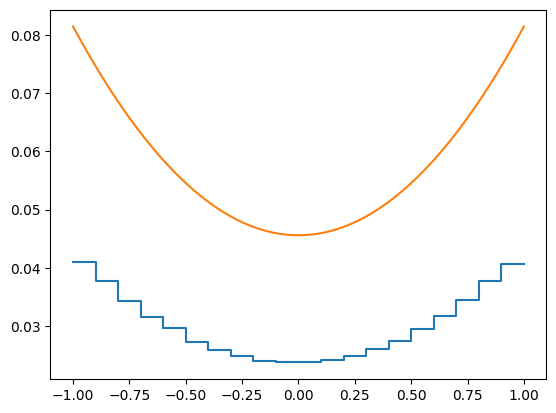

In [26]:
plt.step(xs,bin2)
plt.plot(xx,yy)
plt.show()